<a href="https://colab.research.google.com/github/anphantt2406/Heritage-Health-Prize/blob/main/3_Model_DroppedVer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/HHP_release3/data_processed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/HHP_release3/data_processed


#Import Library

In [32]:
import glob
import math
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn import datasets, ensemble
from sklearn.datasets import make_regression

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#Define some needed function

Predictions are evaluated using root mean squared logarithmic error, referred to henceforth as RMSLE.

$$\varepsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(log(p_i+1) - log(a_i+1)^2 \right )}$$

Where:



*   $i$ is a patient's unique MemberID
*   $n$ is the total number of patients
*   $p_i$ is the prediction made for patient $i$
*   $a_i$ is the actual number of days spent in the hospital by patient $i$





In [33]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [34]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [35]:
def eval(model, X_test, y_test, name = None):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.clip(min=0)
    pred_y = pred_y.clip(max=15)
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,pred_y)
    from sklearn.metrics import mean_squared_log_error
    err = math.sqrt(mean_squared_log_error(y_test,pred_y))
    print("RMSLE of", name, ": %.4f" %rmsle)
    print("R2 value of", name, ": %.4f" %r2)
    print("Err value of", name, ": %.4f" %err)

In [36]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

#Prepare data for training and testing

In this notebook, we use Claims data in Year 1 for training and validation, Claims data in Year 2 for testing.

In [37]:
dataY1_df = pd.read_csv('fulldataY1.csv')
dataY2_df = pd.read_csv('fulldataY2.csv')

In [38]:
dataY1 = dataY1_df.drop("MemberID", axis = 1)
y = dataY1['TARGET']
X = dataY1.drop(['TARGET'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [40]:
dataY2 = dataY2_df.drop("MemberID", axis = 1)
y_test = dataY2['TARGET']
X_test = dataY2.drop(['TARGET'], axis = 1)
X_test = scaler.transform(X_test)

# Regression

## MODEL 1: Linear Regression

RMSLE of linear regression : 0.2178
R2 value of linear regression : 0.4653
Err value of linear regression : 0.2178


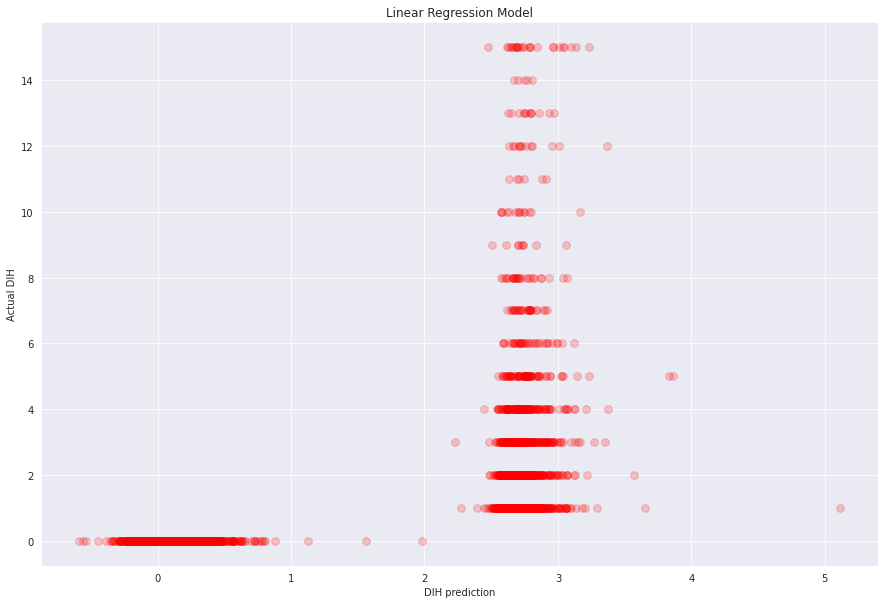

In [41]:
# Create linear regression object
model_1 = LinearRegression()
# Train the model using the training sets
model_1.fit(X_train, y_train)
# Predict on Test set
y_pred_1 = model_1.predict(X_valid)

# Evaluation on Validation set
eval(model_1, X_valid, y_valid,'linear regression')

plt.figure(figsize = (15,10))
plt.scatter(y_pred_1, y_valid, alpha=.2, s = 60, color='r') #alpha helps to show overlapping data
plt.xlabel('DIH prediction')
plt.ylabel('Actual DIH')
plt.title('Linear Regression Model')
plt.show()

## MODEL 2: Stochastic Gradient Descent

In [42]:
from sklearn.linear_model import SGDRegressor

model_2 = SGDRegressor(max_iter=3000, tol=1e-1)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_valid)
eval(model_2, X_valid, y_valid, 'Stochastic Gradient Descent')

RMSLE of Stochastic Gradient Descent : 0.2624
R2 value of Stochastic Gradient Descent : 0.4297
Err value of Stochastic Gradient Descent : 0.2624


In [43]:
model_2i = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False)
model_2i.fit(X_train, y_train)
eval(model_2i, X_valid, y_valid, 'Lasso regression')

RMSLE of Lasso regression : 0.2171
R2 value of Lasso regression : 0.4664
Err value of Lasso regression : 0.2171


##MODEL 3: Neural Network

In [44]:
#(i) Neural Network with default hyperparameters
model_3i = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred_3 = model_3i.predict(X_valid)
eval(model_3i, X_valid, y_valid, 'Neural Network_default')

RMSLE of Neural Network_default : 0.3213
R2 value of Neural Network_default : 0.3633
Err value of Neural Network_default : 0.3213


In [45]:
#(ii) random hyperparameter
model_3ii = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=7, learning_rate='adaptive',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3ii.fit(X_train, y_train)
eval(model_3ii, X_valid, y_valid , 'Neural Network_random')

Iteration 1, loss = 0.95501605
Iteration 2, loss = 0.72511765
Iteration 3, loss = 0.61204549
Iteration 4, loss = 0.54844259
Iteration 5, loss = 0.52139396
Iteration 6, loss = 0.50785353
Iteration 7, loss = 0.50000816
Iteration 8, loss = 0.49487602
Iteration 9, loss = 0.49110394
Iteration 10, loss = 0.48893561
Iteration 11, loss = 0.48587059
Iteration 12, loss = 0.48335305
Iteration 13, loss = 0.48175776
Iteration 14, loss = 0.48019127
Iteration 15, loss = 0.47908061
Iteration 16, loss = 0.47870132
Iteration 17, loss = 0.47737796
Iteration 18, loss = 0.47584979
Iteration 19, loss = 0.47569751
Iteration 20, loss = 0.47492057
Iteration 21, loss = 0.47453685
Iteration 22, loss = 0.47287046
Iteration 23, loss = 0.47287277
Iteration 24, loss = 0.47212899
Iteration 25, loss = 0.47157460
Iteration 26, loss = 0.47068105
Iteration 27, loss = 0.47017723
Iteration 28, loss = 0.47033049
Iteration 29, loss = 0.46933932
Iteration 30, loss = 0.46894559
Iteration 31, loss = 0.46809332
Iteration 32, los

**Hyperparameter Optimization using Grid Search**

In [46]:
#parameter_grid = {'hidden_layer_sizes': [i for i in range(1,10)],
#                  'activation': ['tanh', 'relu'],
#                  'solver': ['sgd','adam'],
#                  'learning_rate': ['constant'],
#                  'learning_rate_init': [0.001],
#                  'alpha': [0.0001],
#                  'max_iter': [1000],}

#rgr = GridSearchCV(MLPRegressor(), parameter_grid,
#                   cv = 5, verbose=True, pre_dispatch='2*n_jobs')
#rgr.fit(X_train, y_train)

#train_mse = mean_squared_error(y_train, rgr.predict(X_train))
#test_mse = mean_squared_error(y_valid, rgr.predict(X_valid))

#print(rgr.best_params_)
#print(rgr.best_score_)
#print("Train MSE:", np.round(train_mse,2))
#print("Test MSE:", np.round(test_mse,2))

In [47]:
from sklearn.neural_network import MLPRegressor

model_3 = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=2, learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3.fit(X_train, y_train)
eval(model_3, X_valid, y_valid, 'Neural Network_gridsearch')

Iteration 1, loss = 1.46029456
Iteration 2, loss = 1.07325999
Iteration 3, loss = 0.97932710
Iteration 4, loss = 0.93854688
Iteration 5, loss = 0.91216409
Iteration 6, loss = 0.88817726
Iteration 7, loss = 0.86328538
Iteration 8, loss = 0.83676347
Iteration 9, loss = 0.80697406
Iteration 10, loss = 0.77468018
Iteration 11, loss = 0.74222692
Iteration 12, loss = 0.71042939
Iteration 13, loss = 0.68001664
Iteration 14, loss = 0.65082594
Iteration 15, loss = 0.62494355
Iteration 16, loss = 0.60292738
Iteration 17, loss = 0.58474585
Iteration 18, loss = 0.56926956
Iteration 19, loss = 0.55650639
Iteration 20, loss = 0.54574038
Iteration 21, loss = 0.53716655
Iteration 22, loss = 0.52997346
Iteration 23, loss = 0.52435772
Iteration 24, loss = 0.52008001
Iteration 25, loss = 0.51676302
Iteration 26, loss = 0.51431150
Iteration 27, loss = 0.51243086
Iteration 28, loss = 0.51106362
Iteration 29, loss = 0.51005918
Iteration 30, loss = 0.50926686
Iteration 31, loss = 0.50880239
Iteration 32, los

## MODEL 4: XGBoost -  Gradient Boost Linear Regression Function

In [48]:
reg = ensemble.GradientBoostingRegressor(n_estimators = 500,
          max_depth = 4,
          min_samples_split= 5,
          learning_rate = 0.01,
          loss = 'ls')
reg.fit(X_train, y_train)
eval(reg, X_valid, y_valid,'Gradient Boosting Regressor')

RMSLE of Gradient Boosting Regressor : 0.2017
R2 value of Gradient Boosting Regressor : 0.4813
Err value of Gradient Boosting Regressor : 0.2017


In [49]:
# Set XGBoost DataMatrix
dmatrix_train = xgboost.DMatrix(data=X_train,label=y_train)
dmatrix_test = xgboost.DMatrix(data=X_test,label=y_test)

[17:24:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:1.368	train-rmse:1.37822	test-RMSLE:0.494536	train-RMSLE:0.497816
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.35926	train-rmse:1.36991	test-RMSLE:0.485122	train-RMSLE:0.489064
[2]	test-rmse:1.352	train-rmse:1.36296	test-RMSLE:0.477078	train-RMSLE:0.481529
[3]	test-rmse:1.3459	train-rmse:1.35707	test-RMSLE:0.470126	train-RMSLE:0.474967
[4]	test-rmse:1.3407	train-rmse:1.35203	test-RMSLE:0.464062	train-RMSLE:0.469201
[5]	test-rmse:1.33624	train-rmse:1.34766	test-RMSLE:0.458739	train-RMSLE:0.464103
[6]	test-rmse:1.33238	train-rmse:1.34386	test-RMSLE:0.454042	train-RMSLE:0.459576
[7]	test-rmse:1.32902	train-rmse:1.34053	test-RMSLE:0.44988	train-RMSLE:0.455543
[8]	test-rmse:1.32609	train-rmse:1.33761	test-RMSLE:0.446182	train-RMSLE:0.451

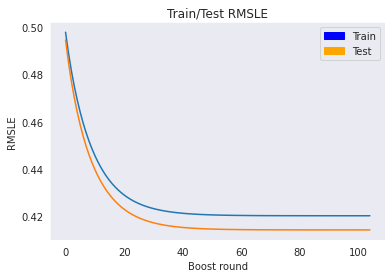

RMSLE Train set: 0.420362


In [50]:
# XGBoost
params = {'objective': 'reg:linear', 'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.5, 'learning_rate': 0.1, 'max_depth': 15, 'lambda': 10,
          'booster': 'gblinear'}
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])

# Final Results

In [51]:
eval(model_1, X_test, y_test,'linear regression')
print('******')
eval(model_2, X_test, y_test, 'Stochastic Gradient Descent')
print('******')
eval(model_2i, X_test, y_test, 'Lasso regression')
print('******')
eval(model_3i, X_test, y_test, 'Neural Network_default')
print('******')
eval(model_3ii, X_test, y_test, 'Neural Network_random')
print('******')
eval(model_3, X_test, y_test, 'Neural Network_gridsearch')
print('******')
eval(reg, X_test, y_test,'Gradient Boosting Regressor')
print('******')
print('Gradient Boost Linear Regression _ RMSLE Test set:', xgb_results['test']['RMSLE'][-1]) 

RMSLE of linear regression : 0.2202
R2 value of linear regression : 0.4577
Err value of linear regression : 0.2202
******
RMSLE of Stochastic Gradient Descent : 0.2692
R2 value of Stochastic Gradient Descent : 0.3969
Err value of Stochastic Gradient Descent : 0.2692
******
RMSLE of Lasso regression : 0.2190
R2 value of Lasso regression : 0.4578
Err value of Lasso regression : 0.2190
******
RMSLE of Neural Network_default : 0.3193
R2 value of Neural Network_default : 0.3482
Err value of Neural Network_default : 0.3193
******
RMSLE of Neural Network_random : 0.2217
R2 value of Neural Network_random : 0.4428
Err value of Neural Network_random : 0.2217
******
RMSLE of Neural Network_gridsearch : 0.2145
R2 value of Neural Network_gridsearch : 0.4601
Err value of Neural Network_gridsearch : 0.2145
******
RMSLE of Gradient Boosting Regressor : 0.1986
R2 value of Gradient Boosting Regressor : 0.4842
Err value of Gradient Boosting Regressor : 0.1986
******
Gradient Boost Linear Regression _ RMS

In [52]:
pred_y = reg.predict(X_test)

submission = pd.DataFrame()
submission['MemberID'] = dataY2_df['MemberID']

pred_y = pred_y.clip(min=0)
pred_y = pred_y.clip(max=15)
# pred_y = pred_y.astype(int)

submission['DIH'] = pred_y
submission.groupby(['DIH']).size()

DIH
0.000000       23
0.000857      385
0.004872      788
0.005935        1
0.006028    56398
            ...  
8.011169        1
8.229543        1
8.326225        1
8.380534        1
9.124800        1
Length: 5977, dtype: int64

In [53]:
submission[submission['DIH']>=2]

,MemberID,DIH
16,20072,2.963246
22,28243,2.604812
24,32491,4.520432
27,42395,2.576855
34,55920,3.435456
...,...,...
66977,99926212,3.109424
66991,99941797,3.092237
67011,99966197,2.006043
67017,99973127,3.053945


In [54]:
dataY2_df[dataY2_df['MemberID']==	99977491]

,MemberID,AgeAtFirstClaim,Male,Female,Unknown,no_Claims,no_Providers,no_Specialties,no_PCG,no_Procedure,sum_PayDelay,sum_LOS,Specialty_Anesthesiology,Specialty_Diagnostic Imaging,Specialty_Emergency,Specialty_General Practice,Specialty_Internal,Specialty_Laboratory,Specialty_Obstetrics and Gynecology,Specialty_Other,Specialty_Pathology,Specialty_Pediatrics,Specialty_Rehabilitation,Specialty_Surgery,Place_Ambulance,Place_Home,Place_Independent Lab,Place_Inpatient Hospital,Place_Office,Place_Other,Place_Outpatient Hospital,Place_Urgent Care,DSFS_0- 1 month,DSFS_1- 2 months,DSFS_10-11 months,DSFS_11-12 months,DSFS_2- 3 months,DSFS_3- 4 months,DSFS_4- 5 months,DSFS_5- 6 months,...,PCG_PERVALV,PCG_PNCRDZ,PCG_PNEUM,PCG_PRGNCY,PCG_RENAL1,PCG_RENAL2,PCG_RENAL3,PCG_RESPR4,PCG_ROAMI,PCG_SEIZURE,PCG_SEPSIS,PCG_SKNAUT,PCG_STROKE,PCG_TRAUMA,PCG_UTI,Charlson_0,Charlson_1-2,Charlson_3-4,Charlson_5+,Procedure_ANES,Procedure_EM,Procedure_MED,Procedure_PL,Procedure_RAD,Procedure_SAS,Procedure_SCS,Procedure_SDS,Procedure_SEOA,Procedure_SGS,Procedure_SIS,Procedure_SMCD,Procedure_SMS,Procedure_SNS,Procedure_SO,Procedure_SRS,Procedure_SUS,DrugSum,LabSum,TARGET,CLASS
67019,99977491,65,0,1,0,6,2,1,3,2,235,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,3,3,0,0,0,4,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,24,0,3,1
